In [351]:
#Dec 19, 2023

#This script looks at trends in temperature and smoke ozone

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import seaborn as sns
import os
import requests
import string
import pickle

mpl.rcParams['figure.dpi'] = 200



### INPUT ###

ap2014_path = '/content/drive/MyDrive/colab/consulting/mv/Temp_2002-2012.xlsx'
ap2024_path = '/content/drive/MyDrive/colab/consulting/mv/Temp_2013-2023.xlsx'
meta_path = '/content/drive/MyDrive/colab/consulting/mv/SelectMeta.xlsx'
fig_path = '/content/drive/MyDrive/colab/consulting/mv/figs/task2'
ozone_1h_path = '/content/drive/MyDrive/colab/consulting/mv/ozone_1h.pkl'
ozone_8h_path = '/content/drive/MyDrive/colab/consulting/mv/ozone_8h.pkl'


stations = ['T031','T033']  #testing
# stations = ['T001','T004','T006','T009','T012','T013','T014','T015','T017','T018','T020','T026','T027','T029','T030','T031','T032','T033','T034','T035','T043','T044','T045','T046','T050']



# stations =
quantiles = [0.5, 0.75, 0.95, 1]
# lmt_1h = [[5,40], [15,45], [30,50]]  #plot limits for 1h plots
# lmt_8h = [[5,40], [15,45], [30,45]]  #plot limits for 1h plots


### end of input ###




In [2]:
#import data
ap2014 = pd.read_excel(ap2014_path,\
                      header=2, index_col=0, skiprows = lambda x: x in [3, 4], \
                       na_values=['NoData','Calib','<Samp','Zero','Down','InVld','Span','RS232','AutoCal','Purge','Spare','OutCal','Vandalism','Change'])


In [3]:
ap2024 = pd.read_excel(ap2024_path,\
          header=2, index_col=0, skiprows = lambda x: x in [3, 4], \
                         na_values=['NoData','Calib','<Samp','Zero','Down','InVld','Span','RS232','AutoCal','Purge','Spare','OutCal','Vandalism','Change'])

In [4]:
#import metadata
meta = pd.read_excel(meta_path)
meta['MV_ID'] = meta.MV_ID.apply(lambda x: 'T' + x[1:].zfill(3))
meta.set_index(meta.MV_ID, inplace=True)
meta.index.rename('stations', inplace=True)
meta.convert_dtypes()

NAPS_ID MV_ID                     StationName  \
stations                                                  
T001       100112  T001              DOWNTOWN VANCOUVER   
T002       100118  T002             VANCOUVER-KITSILANO   
T004       100110  T004         BURNABY-KENSINGTON PARK   
T006       100121  T006  NORTH VANCOUVER-SECOND NARROWS   
T009       100111  T009                      PORT MOODY   
T012       101101  T012                      CHILLIWACK   
T013       100125  T013                     NORTH DELTA   
T014       100126  T014                BURNABY MOUNTAIN   
T015       100127  T015                     SURREY EAST   
T017       100128  T017                  RICHMOND SOUTH   
T018       100119  T018                   BURNABY SOUTH   
T020       101202  T020                    PITT MEADOWS   
T022       100133  T022                BURNABY-BURMOUNT   
T023       100136  T023            BURNABY-CAPITOL HILL   
T024       100137  T024                   BURNABY NORTH   
T025       100131  T025                   SEYMOUR FALLS   
T026       100132  T026      NORTH VANCOUVER-MAHON PARK   
T027       101301  T027                         LANGLEY   
T029       101401  T029                            HOPE   
T030       101501  T030                     MAPLE RIDGE   
T031       100134  T031                RICHMOND AIRPORT   
T032       100135  T032                       COQUITLAM   
T033       101003  T033            ABBOTSFORD-MILL LAKE   
T034       101004  T034              ABBOTSFORD AIRPORT   
T035       100138  T035                   HORSESHOE BAY   
T039       100140  T039                      TSAWWASSEN   
T043       103602  T043                         MISSION   
T044       100143  T044                         AGASSIZ   
T045       101005  T045              ABBOTSFORD AIRPORT   
T046       100103  T046                 NEW WESTMINSTER   
T050       100141  T050           VANCOUVER CLARK DRIVE   

                                                    Address     Municipality  \
stations                                                                       
T001      ROBSON SQUARE - ROBSON AND HORNBY STREET Room ...        VANCOUVER   
T002                                  2550 WEST 10TH AVENUE        VANCOUVER   
T004                               6400 E. HASTINGS STREET           BURNABY   
T006                                     75 RIVERSIDE DRIVE  NORTH VANCOUVER   
T009                             MOODY STREET AND ESPLANADE       PORT MOODY   
T012                CHILLIWACK AIRPORT  46360 Airport Road.       CHILLIWACK   
T013                                    8544 - 116TH STREET            DELTA   
T014           SIMON FRASER UNIVERSITY - West Mall Building          BURNABY   
T015           Clayton Reservoir - 19000 BLOCK, 72ND AVENUE           SURREY   
T017                          WILLIAMS at 10371 ARAGON ROAD         RICHMOND   
T018                                     5455 RUMBLE STREET          BURNABY   
T020      MEADOWLANDS ELEM. SCHOOL - 18477 DEWDNEY TRUNK...     PITT MEADOWS   
T022                                 7815 SHELLMONT STREET           BURNABY   
T023                                      GROSVENOR CRESENT          BURNABY   
T024                               ETON AND MADISON AVENUE           BURNABY   
T025                                           SEYMOUR DAM   NORTH VANCOUVER   
T026                           16TH STREET AND JONES AVENUE  NORTH VANCOUVER   
T027                                    23752 - 52ND AVENUE          LANGLEY   
T029              HOPE AIRPORT - 62720 AIRPORT ROAD, RR#2               HOPE   
T030      GOLDEN EARS ELEM SCHOOL - 23124 118th AVE. AT ...      MAPLE RIDGE   
T031                                 3153 TEMPLETON STREET          RICHMOND   
T032                    1250 PINETREE WAY - Douglas College        COQUITLAM   
T033                        32995 BEVAN AVENUE AND PRIMROSE       ABBOTSFORD   
T034                                      31790 WALMSLEY RD   

In [6]:
#convert index to datetime and data to float
ap2014.index = pd.to_datetime(ap2014.index)
# ap2014.convert_dtypes()
# ap2014['jday'] = ap2014.index.day_of_year

ap2024.index = pd.to_datetime(ap2024.index)
# ap2024.convert_dtypes()
# ap2024['jday'] = ap2024.index.day_of_year


In [7]:
#assemble data, do grouping and averaging
temp_1h = pd.concat([ap2014, ap2024])
grp_1h = temp_1h.groupby(temp_1h.index.year)

In [26]:
#-----optional: check for random missing data strings-------
# pd.to_numeric(temp_1h.T033)

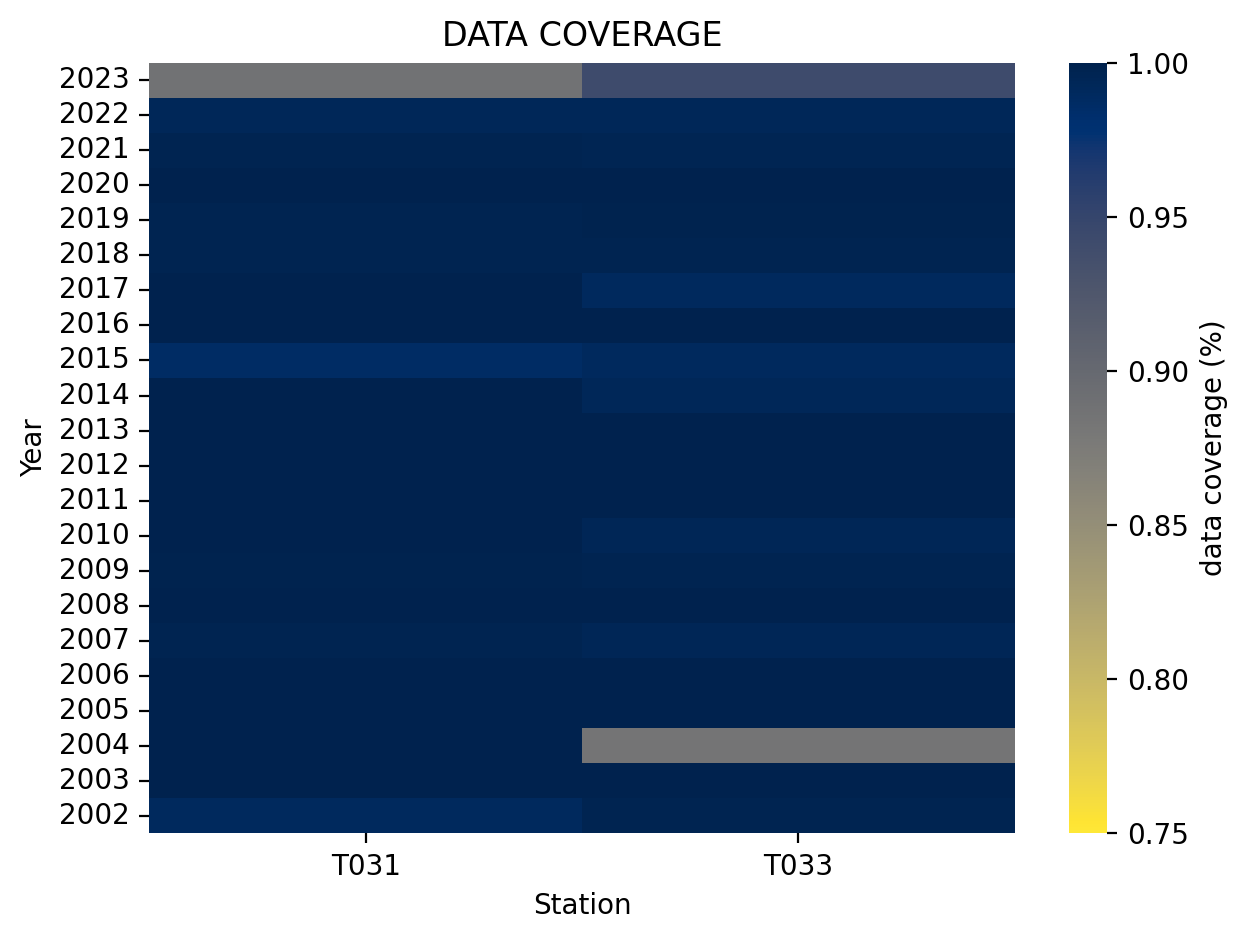

In [9]:
#look at how complete the data is
data_frac = grp_1h.count()/8760
plt.figure()
ax = plt.gca()
sns.heatmap(data_frac, vmin=0.75, vmax=1,cmap='cividis_r',cbar_kws={'label': 'data coverage (%)'})
ax.set(ylabel='Year', xlabel='Station', title='DATA COVERAGE')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(fig_path,'data_coverage.pdf'))

In [ ]:
# #sanity check: outlier check
# ozone_1h.boxplot()

In [10]:
# set up storage dataframe for trends
qKeys = ['stations'] + [f'Q{i}' for i in quantiles] + ['lat'] + ['lon']
trends = pd.DataFrame(columns = qKeys)
trends['stations'] = stations
trends.set_index(trends.stations, inplace=True)


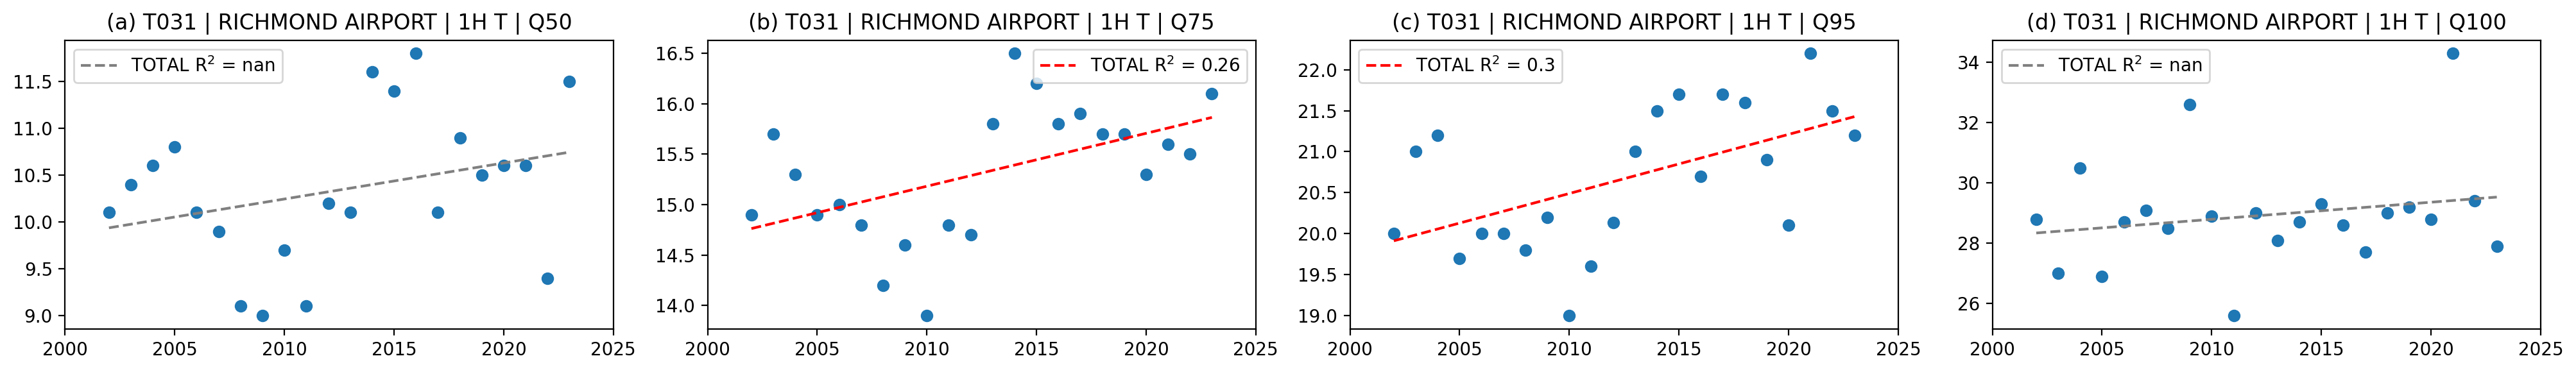

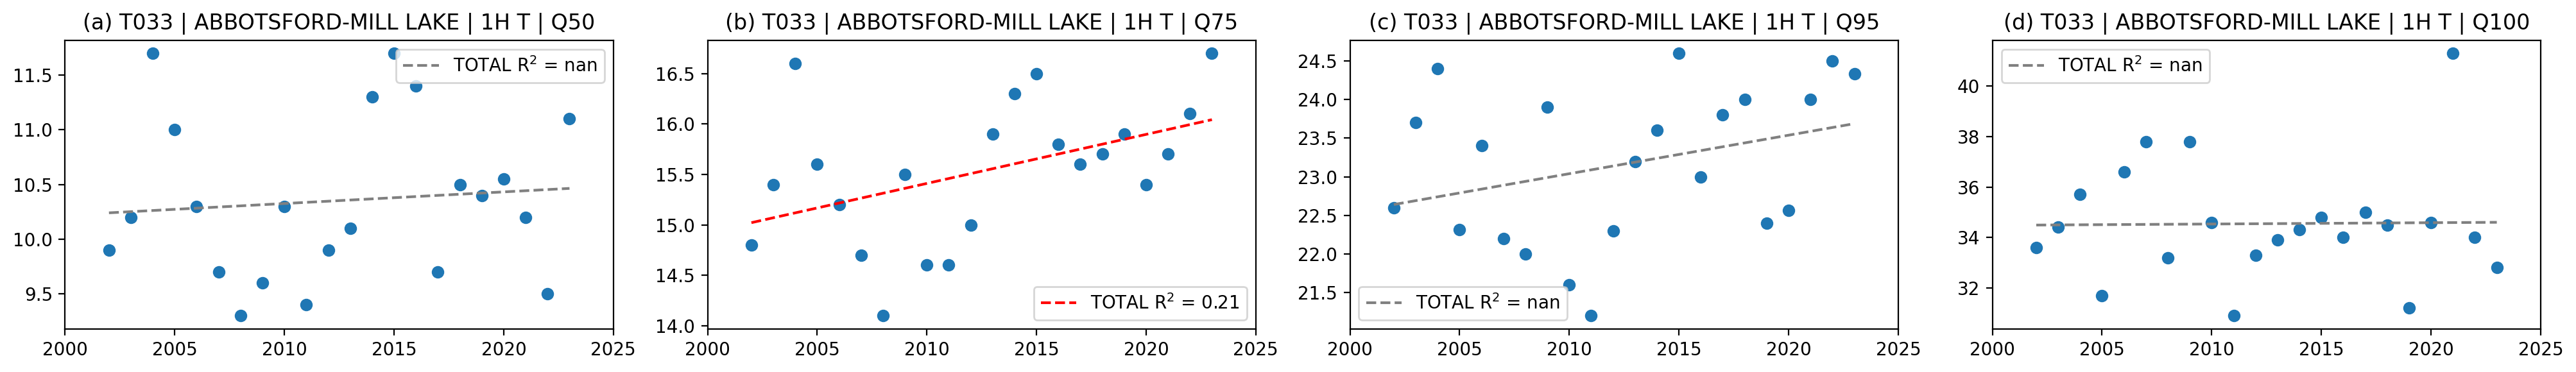

In [11]:
 #-------------1H TEMP------------------
plt_tag = [f'({i})' for i in list(string.ascii_lowercase)]

#loop through stations
for nStn, stn in enumerate(stations):

  #loop through quantiles
  numQnt = len(quantiles) + 1
  plt.figure(figsize=(5*numQnt,3))
  for nQ, qnt in enumerate(quantiles):

    #gather data
    q = grp_1h[stn].quantile(q=qnt)

    #------trendline------
    #add constant to predictor variables
    x = sm.add_constant(q.index.values)
    #fit linear regression model
    model = sm.OLS(q, x, missing='drop').fit()

    #get trend for last N years
    trend = model.predict(exog=x)
    #if significant, save the trend
    if model.pvalues.x1<0.05:
      trends.loc[stn,f'Q{qnt}'] = model.params.x1
    trends.loc[stn,['lat','lon']] = meta.loc[stn,['Lat','Lon']].values


    #----plotting-----
    plt.subplot(1,numQnt,nQ + 1)
    ax = plt.gca()
    plt.scatter(y = q, x=q.index)
    plt.plot(x[:,1],trend,c=['red' if model.pvalues.x1<0.05 else 'gray'][0],linestyle='--',\
            label = f'TOTAL R$^2$ = {[round(model.rsquared,2) if model.pvalues.x1<0.05 else "nan"][0]}')
    ax.set(title = f'{plt_tag[nQ]} {stn} | {meta.loc[stn,"StationName"]} | 1H T | Q{int(qnt*100)}', xlim=[2000, 2025])
    plt.legend()
  plt.tight_layout()
  # plt.savefig(os.path.join(fig_path, 'stn_trends','1H',f'{stn}_O3_1H.pdf'),bbox_inches = 'tight')


In [12]:
#---------- HEAT WAVE ANALYSIS ---------------
# ECCC heat warning criteria
#https://colab.research.google.com/drive/1WDPDInVwAqa7F3tqmwKTizbonSaF1wYr#scrollTo=ZGFLnn6-9zqH

#need two consecutive days
eccc_dfn = pd.DataFrame({'station' : stations,'tmin': np.empty(len(stations)),'tmax':np.empty(len(stations))})
eccc_dfn.set_index('station',inplace=True)

In [13]:
#manually assign values for stations depending on locatoin
eccc_dfn['tmin'].T031 = 16
eccc_dfn['tmin'].T033 = 17
eccc_dfn['tmax'].T031 = 29
eccc_dfn['tmax'].T033 = 33

In [15]:
#get daily max for each day of the year within each year
daily_1h_max = temp_1h[stations].groupby([temp_1h.index.year,temp_1h.index.day_of_year]).max()
daily_1h_max.index.set_names(['year','day'], inplace=True)

#get daily min
daily_1h_min = temp_1h[stations].groupby([temp_1h.index.year,temp_1h.index.day_of_year]).min()
daily_1h_min.index.set_names(['year','day'], inplace=True)

<ipython-input-68-b199e8c10247>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex_cnt_1h['period'].loc[2002:2012] = 'AP2014'


[Text(0.5, 0, 'station'),
 Text(0, 0.5, 'count'),
 Text(0.5, 1.0, 'TEMPERATURE EXCEEDANCES BY STATION')]

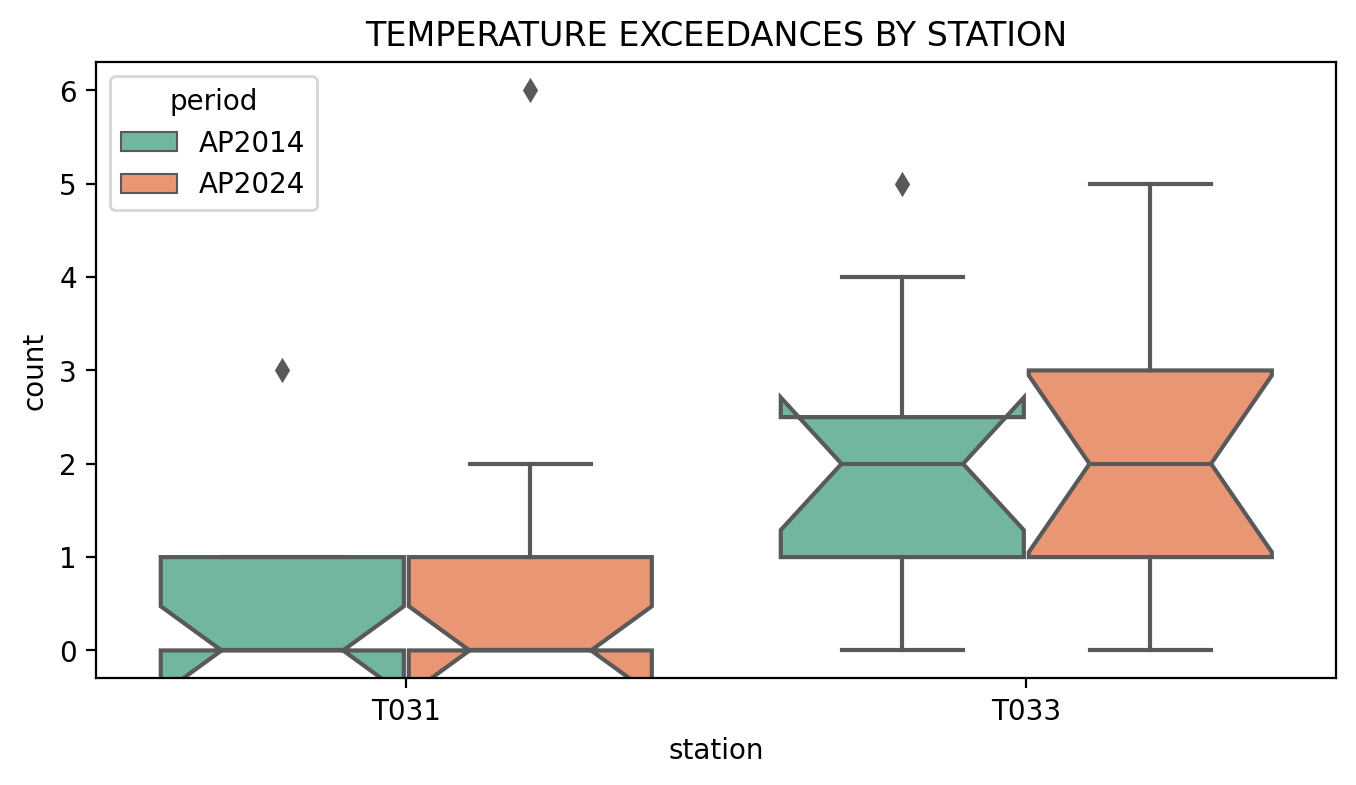

In [68]:
#loop through stations
ex_cnt_1h = pd.DataFrame()

for nStn, stn in enumerate(stations):
  stn_tmax = eccc_dfn.loc[stn,'tmax']
  ex_cnt_1h[stn] = daily_1h_max[stn].ge(stn_tmax).reset_index(0).groupby('year').agg('sum')
ex_cnt_1h['period'] = np.nan
ex_cnt_1h['period'].loc[2002:2012] = 'AP2014'
ex_cnt_1h['period'].loc[2013:2024] = 'AP2024'

plt.figure(figsize=(8,4))
ax = plt.gca()
sns.boxplot(x='variable',y='value',hue='period',data=ex_cnt_1h.melt(id_vars='period',value_vars=stations), notch=True, palette='Set2')
ax.set(xlabel='station',ylabel='count',title='TEMPERATURE EXCEEDANCES BY STATION')
# # plt.savefig(os.path.join(fig_path,'1H_O3_NormExceedances.pdf'),bbox_inches = 'tight')

In [73]:
#no look at achtual events
heat_events = pd.DataFrame(columns = ('year','station','start','length'))
cnt = 0
for nStn, stn in enumerate(stations):
  stn_tmax = eccc_dfn.loc[stn,'tmax']
  stn_tmin = eccc_dfn.loc[stn,'tmin']
  # ex_cnt_1h[stn] = daily_1h_max[stn].ge(stn_tmax).reset_index(0).groupby('year').agg('sum')

  #apply ECCC criteria
  single_day_criteria = daily_1h_max[stn].loc[(daily_1h_max[stn].ge(stn_tmax)) & (daily_1h_min[stn].ge(stn_tmin))]

  #check for consecutive days meeting the criteria
  for item in single_day_criteria.reset_index(0).groupby('year'):
    select_days = item[1].index.to_list()
    if len(select_days) > 1:
      if 1 in np.diff(select_days):
        # print(item[0],item[1].index[np.where(np.diff(select_days)==1)])
        heat_start = item[1].index[np.where(np.diff(select_days)==1)]
        print(f'{stn} | {item[0]} | Start day: {heat_start[0]} ndays = {len(heat_start)+1}')
        heat_events.loc[cnt, ['year','station','start','length']] = [item[0],stn,heat_start[0],len(heat_start)+1]
        cnt = cnt + 1

T031 | 2009 | Start day: 209 ndays = 3
T031 | 2021 | Start day: 177 ndays = 4
T033 | 2004 | Start day: 205 ndays = 2
T033 | 2006 | Start day: 202 ndays = 2
T033 | 2009 | Start day: 209 ndays = 3
T033 | 2010 | Start day: 226 ndays = 2
T033 | 2021 | Start day: 177 ndays = 3


In [76]:
heat_events

year station start length
0  2009    T031   209      3
1  2021    T031   177      4
2  2004    T033   205      2
3  2006    T033   202      2
4  2009    T033   209      3
5  2010    T033   226      2
6  2021    T033   177      3

In [352]:
#-------plot what happens to ozone during heat events---------
ozone_1h = pd.read_pickle(ozone_1h_path)
ozone_8h = pd.read_pickle(ozone_8h_path)

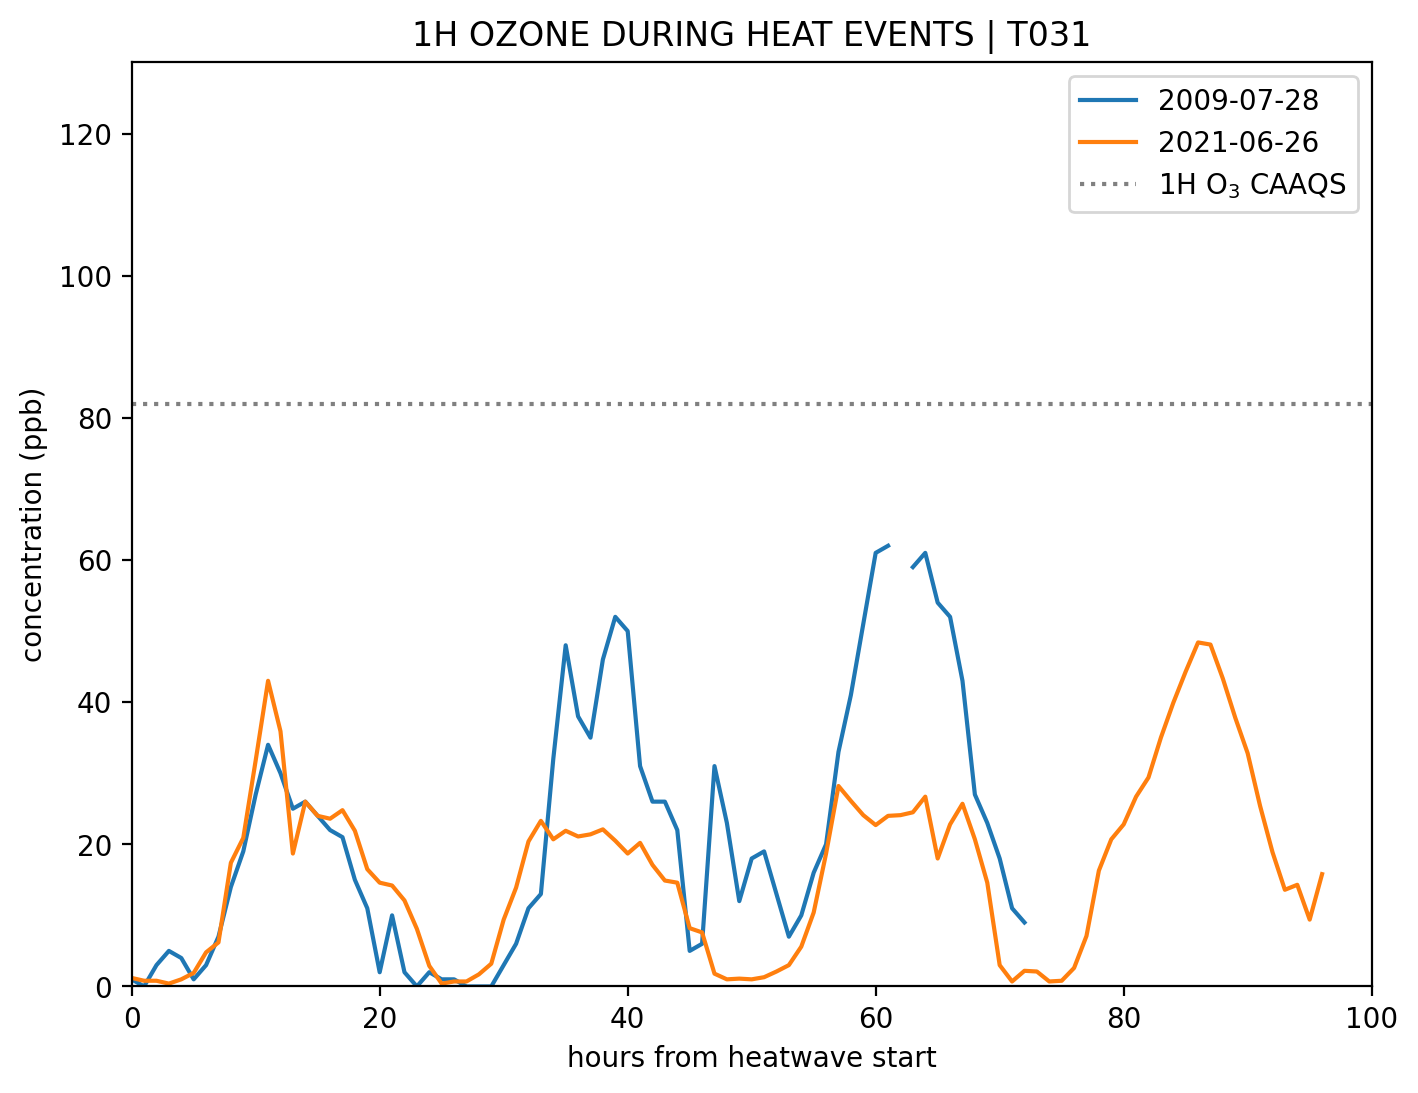

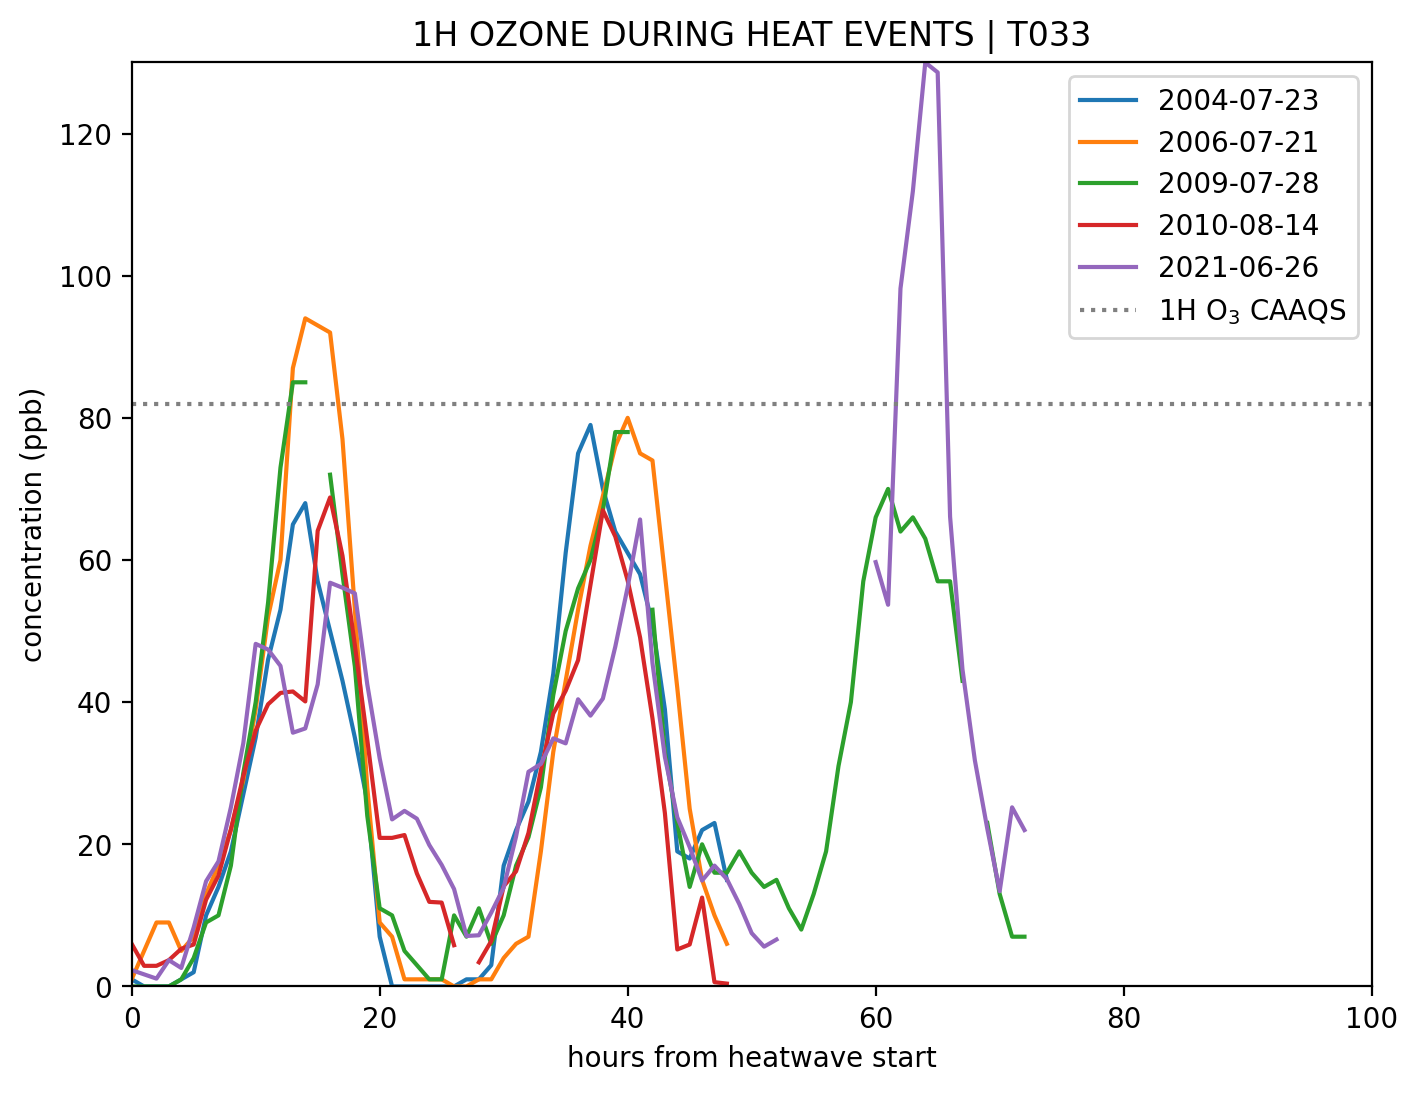

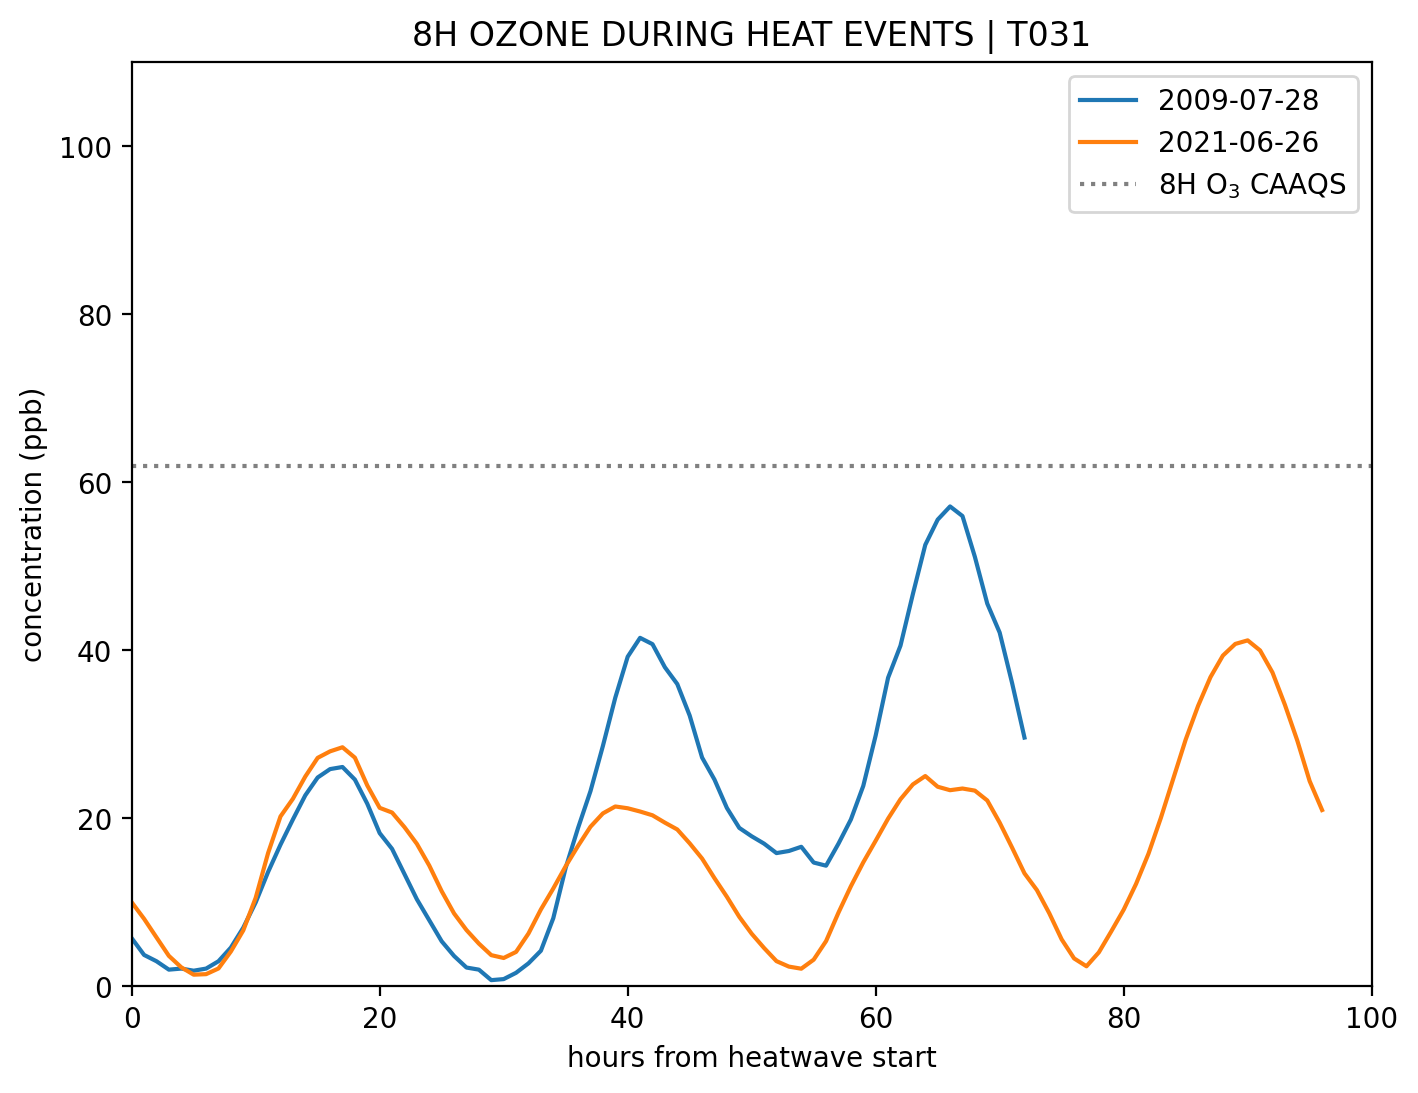

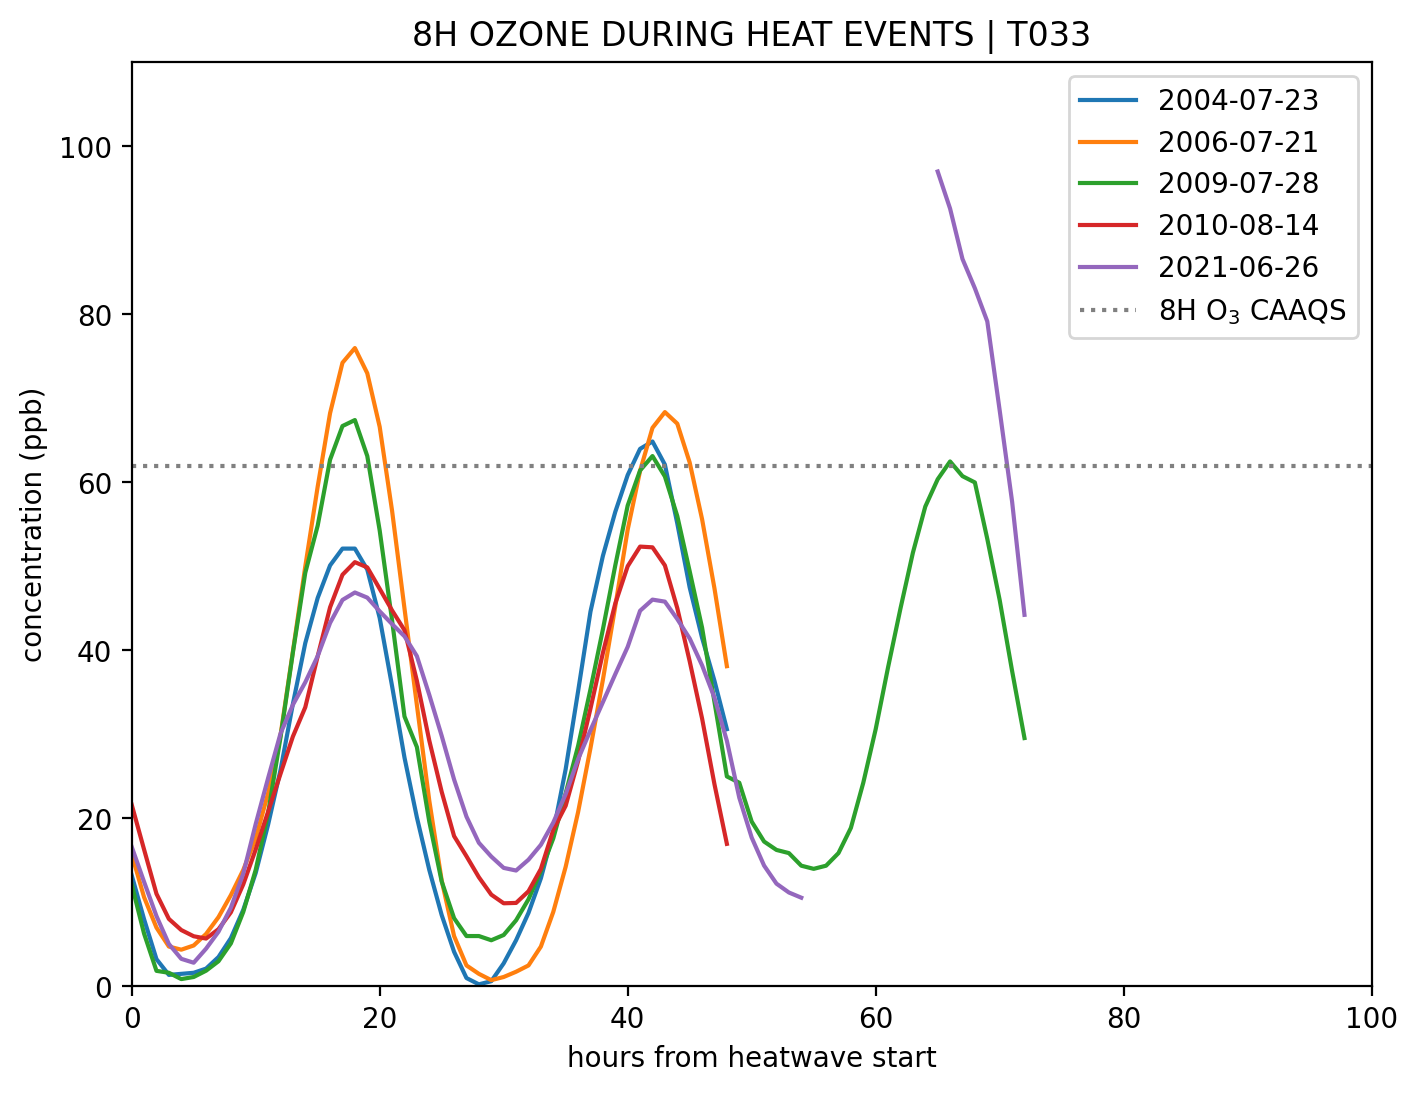

In [354]:
#plot what happenned with ozone for each heat wave
#-------1h ozone-------------
for stn in heat_events.groupby('station'):
  plt.figure(figsize=(8,6))
  ax=plt.gca()
  for event in stn[1].groupby('year'):
    heat_start = pd.to_datetime(event[1].year * 1000 + event[1].start, format='%Y%j').item()
    heat_end = heat_start + pd.Timedelta(days=event[1].length.item())
    wave_ozone = ozone_1h.loc[heat_start:heat_end,stn[0]]
    wave_ozone.index = [int(idx.total_seconds() / 3600) for idx in (wave_ozone.index - wave_ozone.index[0])]
    wave_ozone.plot(label=heat_start.strftime('%Y-%m-%d'))
  plt.axhline(y=82,c='gray',linestyle=':',label=f'1H O$_3$ CAAQS')
  plt.legend()
  ax.set(title=f'1H OZONE DURING HEAT EVENTS | {stn[0]}', xlabel='hours from heatwave start',ylabel='concentration (ppb)',\
         xlim=[0,100], ylim=[0,130])

#-------8h ozone-------------
for stn in heat_events.groupby('station'):
  plt.figure(figsize=(8,6))
  ax=plt.gca()
  for event in stn[1].groupby('year'):
    heat_start = pd.to_datetime(event[1].year * 1000 + event[1].start, format='%Y%j').item()
    heat_end = heat_start + pd.Timedelta(days=event[1].length.item())
    wave_ozone = ozone_8h.loc[heat_start:heat_end,stn[0]]
    wave_ozone.index = [int(idx.total_seconds() / 3600) for idx in (wave_ozone.index - wave_ozone.index[0])]
    wave_ozone.plot(label=heat_start.strftime('%Y-%m-%d'))
  plt.axhline(y=62,c='gray',linestyle=':',label=f'8H O$_3$ CAAQS')
  plt.legend()
  ax.set(title=f'8H OZONE DURING HEAT EVENTS | {stn[0]}', xlabel='hours from heatwave start',ylabel='concentration (ppb)',\
         xlim=[0,100], ylim=[0,110])




In [310]:
stn[0]

'T031'

In [300]:
# wave_ozone.index = wave_ozone.index - wave_ozone.index[0]
wave_ozone.index = [int(idx.total_seconds() / 3600) for idx in (wave_ozone.index - wave_ozone.index[0])]

In [328]:
ozone_1h.T033.loc['2009-07-29 00:00:00':'2009-07-30 00:00:00']

Date & Time
2009-07-29 00:00:00     1.0
2009-07-29 01:00:00     1.0
2009-07-29 02:00:00    10.0
2009-07-29 03:00:00     7.0
2009-07-29 04:00:00    11.0
2009-07-29 05:00:00     6.0
2009-07-29 06:00:00    10.0
2009-07-29 07:00:00    17.0
2009-07-29 08:00:00    21.0
2009-07-29 09:00:00    28.0
2009-07-29 10:00:00    41.0
2009-07-29 11:00:00    50.0
2009-07-29 12:00:00    56.0
2009-07-29 13:00:00    60.0
2009-07-29 14:00:00    67.0
2009-07-29 15:00:00    78.0
2009-07-29 16:00:00    78.0
2009-07-29 17:00:00     NaN
2009-07-29 18:00:00    53.0
2009-07-29 19:00:00    33.0
2009-07-29 20:00:00    23.0
2009-07-29 21:00:00    14.0
2009-07-29 22:00:00    20.0
2009-07-29 23:00:00    16.0
2009-07-30 00:00:00    16.0
Name: T033, dtype: float64

In [264]:
wave_ozone.reset_index(drop = True, inplace=True)

In [270]:
wave_ozone

Date & Time
0 days 00:00:00     2.3
0 days 01:00:00     1.7
0 days 02:00:00     1.1
0 days 03:00:00     3.7
0 days 04:00:00     2.6
                   ... 
2 days 20:00:00    31.8
2 days 21:00:00    22.2
2 days 22:00:00    13.4
2 days 23:00:00    25.2
3 days 00:00:00    22.0
Name: T033, Length: 73, dtype: float64

In [251]:
# wave_ozone.index.dt.days

TypeError: ignored

In [79]:

# #check for consecutive days meeting the criteria
# for item in single_day_criteria.reset_index(0).groupby('year'):
#   select_days = item[1].index.to_list()
#   if len(select_days) > 1:
#     if 1 in np.diff(select_days):
#       print(item)

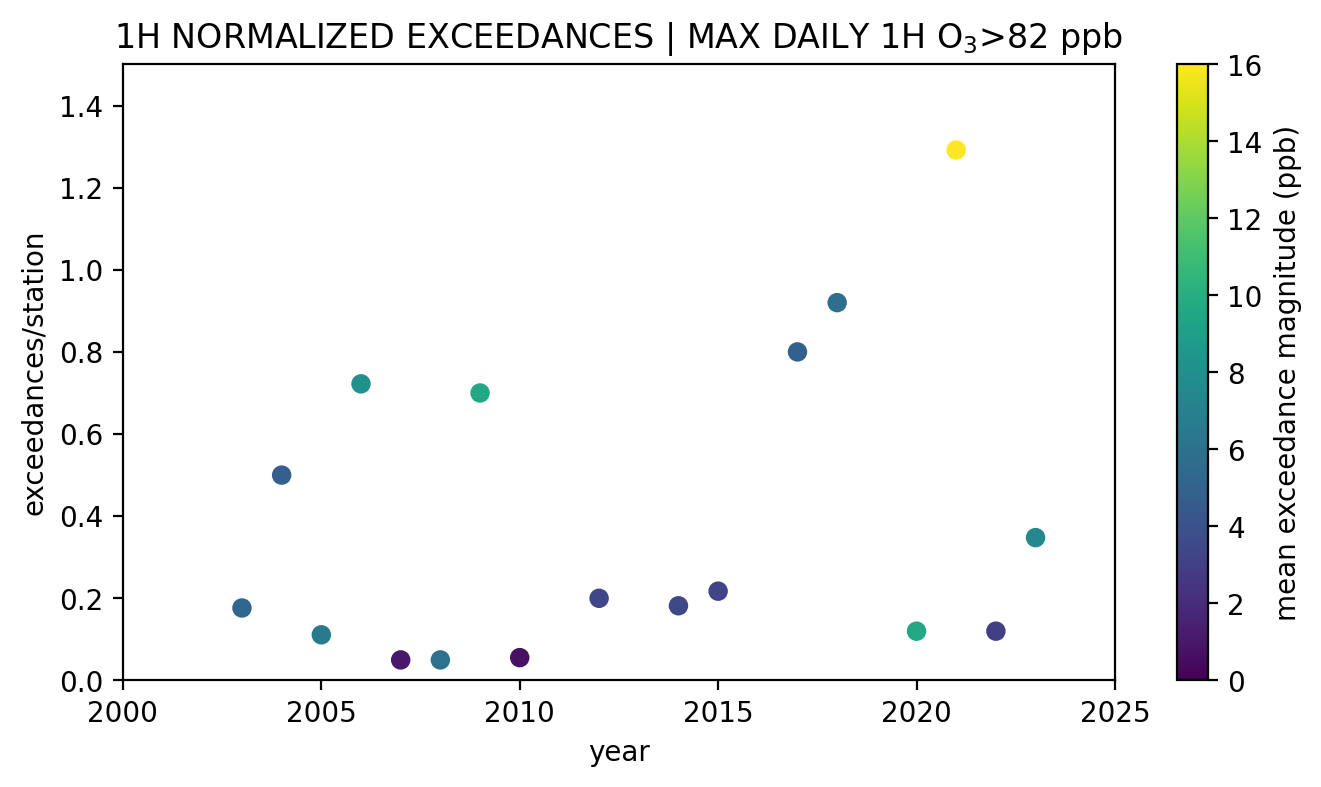

In [ ]:
# ------- ANALYSIS OF FREQ AND MAG OF EXCEEDANCE ---------


# --------1h ozone analysis-------
#get daily max for each day of the year within each year
daily_1h_max = ozone_1h[select_stations].groupby([ozone_1h.index.year,ozone_1h.index.day_of_year]).max()
daily_1h_max.index.set_names(['year','day'], inplace=True)
#get count of exceedances by station and year
ex_cnt_1h = daily_1h_max.gt(82).reset_index(0).groupby('year').agg('sum')
#sum across all stations, weigh by station count
ex_total_1h = ex_cnt_1h.sum(axis='columns')
active_stn = data_frac.gt(0.75).sum(axis='columns')
normalized_ex = ex_total_1h/active_stn
#get average magnitude of exceedance by year
diff_daily_1h = daily_1h_max - 82
diff_daily_1h[diff_daily_1h.le(0)] = np.nan
mag_1h = diff_daily_1h.reset_index(0).groupby('year').agg('mean').mean(axis='columns')

#plot frequency of 1H exceedanes by year
plt.figure(figsize=(8,4))
ax = plt.gca()
plt.scatter(normalized_ex.index, normalized_ex,\
            c=mag_1h, vmin=0, vmax = 16)
ax.set(title = f'1H NORMALIZED EXCEEDANCES | MAX DAILY 1H O$_3$>82 ppb',\
       xlabel = 'year', ylabel='exceedances/station', ylim = [0,1.5], xlim=[2000, 2025])
plt.colorbar(label = 'mean exceedance magnitude (ppb)')
plt.savefig(os.path.join(fig_path,'1H_O3_NormExceedances.pdf'),bbox_inches = 'tight')

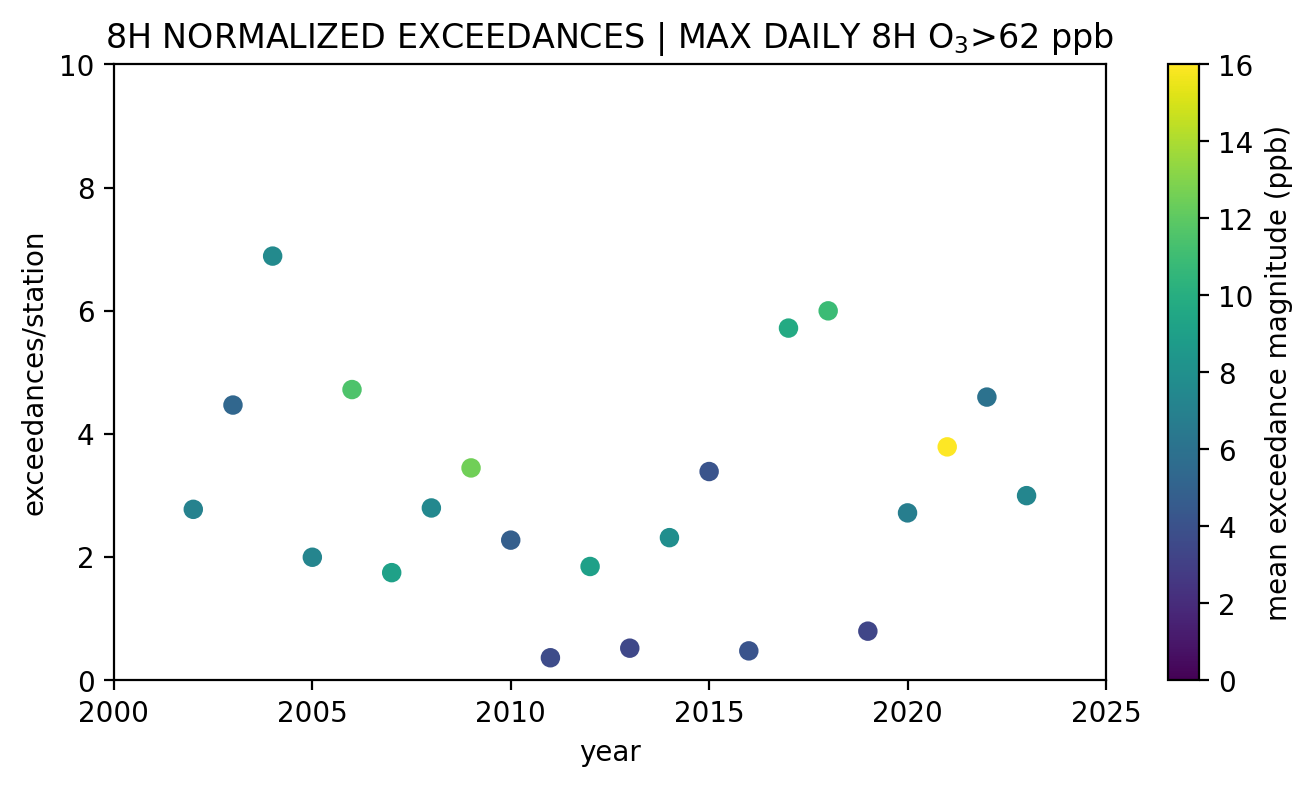

In [ ]:
# --------8h ozone analysis-------
#get daily max for each day of the year within each year
daily_8h_max = ozone_1h[select_stations].groupby([ozone_8h.index.year,ozone_8h.index.day_of_year]).max()
daily_8h_max.index.set_names(['year','day'], inplace=True)
#get count of exceedances by station and year
ex_cnt_8h = daily_8h_max.gt(62).reset_index(0).groupby('year').agg('sum')
#sum across all stations, weigh by station count
ex_total_8h = ex_cnt_8h.sum(axis='columns')
normalized_ex_8h = ex_total_8h/active_stn
#get average magnitude of exceedance by year
diff_daily_8h = daily_8h_max - 62
diff_daily_8h[diff_daily_8h.le(0)] = np.nan
mag_8h = diff_daily_8h.reset_index(0).groupby('year').agg('mean').mean(axis='columns')

#plot frequency of 1H exceedanes by year
plt.figure(figsize=(8,4))
ax = plt.gca()
plt.scatter(normalized_ex_8h.index, normalized_ex_8h,\
            c=mag_8h,vmin=0,vmax=16)
ax.set(title = f'8H NORMALIZED EXCEEDANCES | MAX DAILY 8H O$_3$>62 ppb',\
       xlabel = 'year', ylabel='exceedances/station', xlim=[2000, 2025],ylim=[0,10])
plt.colorbar(label = 'mean exceedance magnitude (ppb)')
plt.savefig(os.path.join(fig_path,'8H_O3_NormExceedances.pdf'),bbox_inches = 'tight')

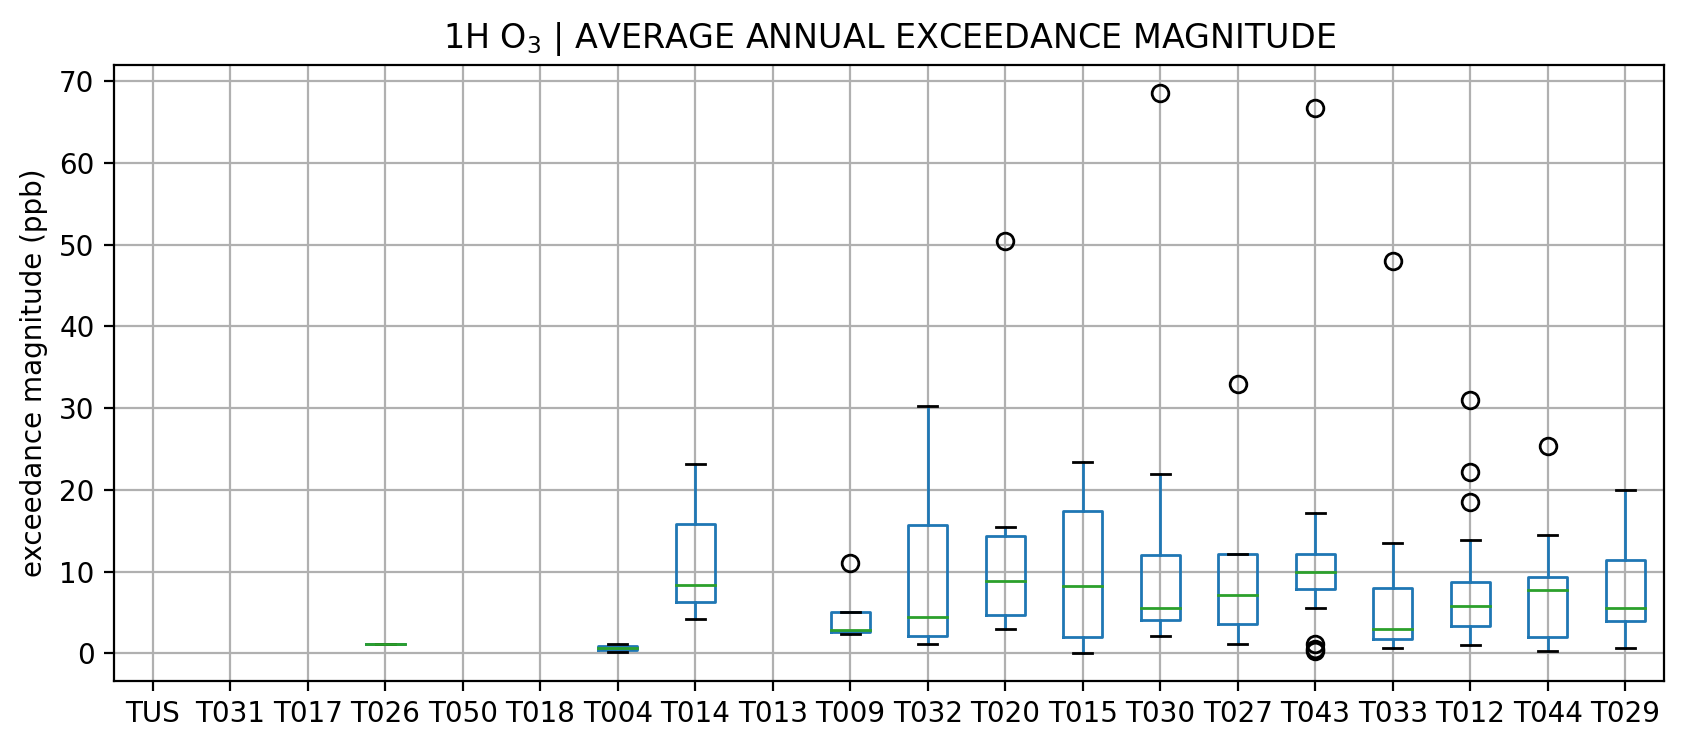

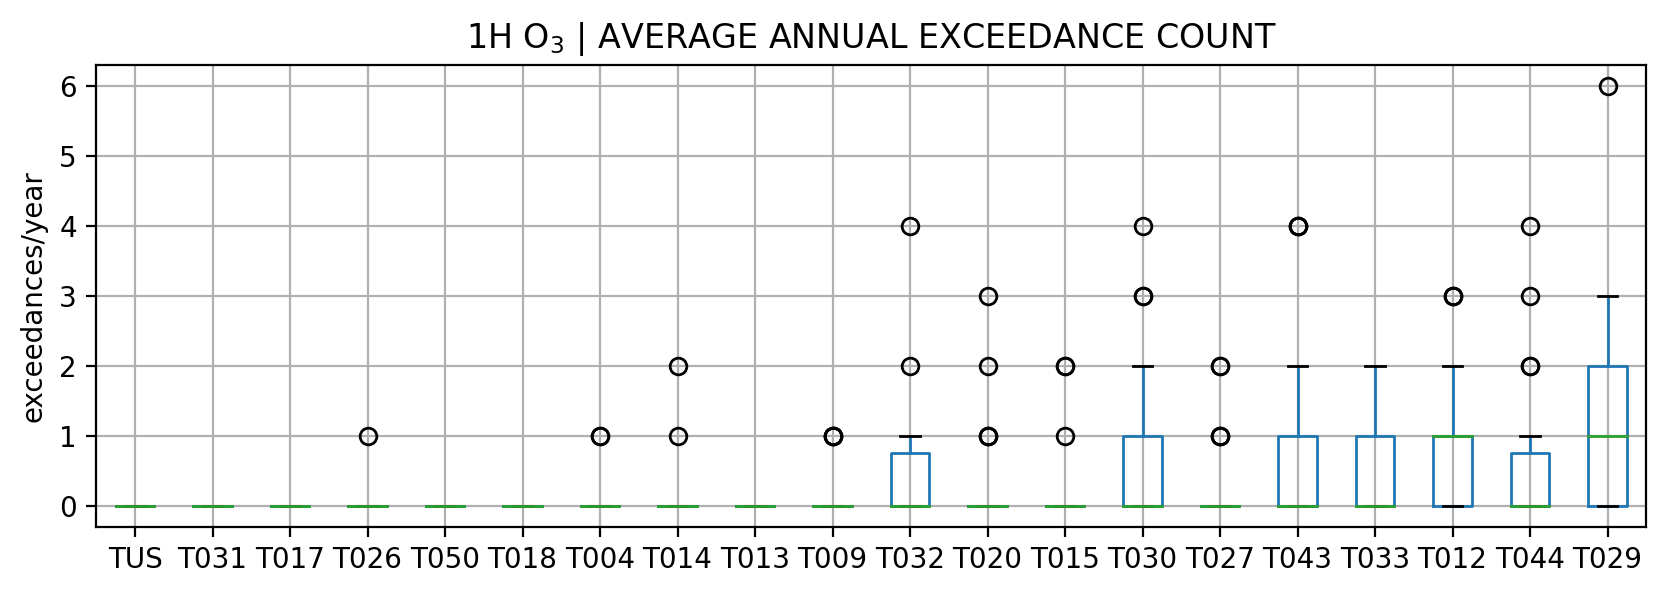

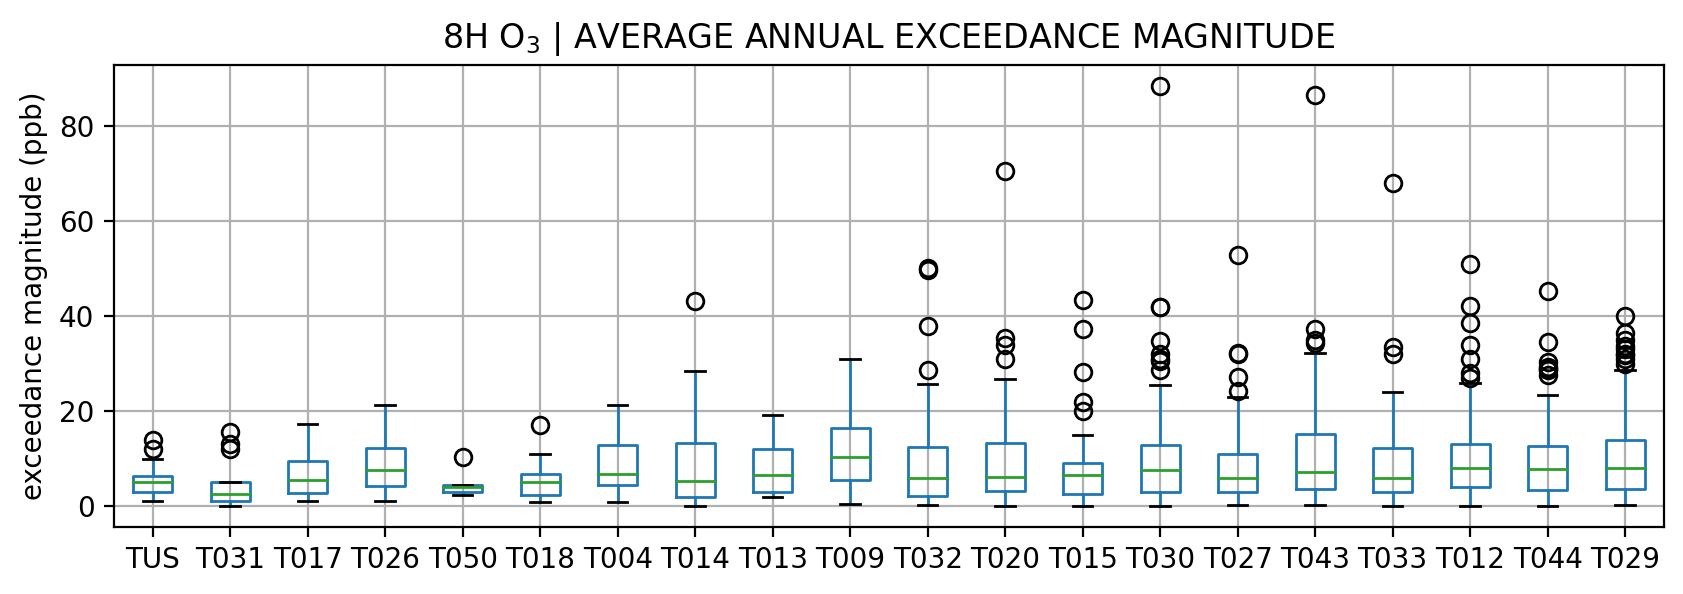

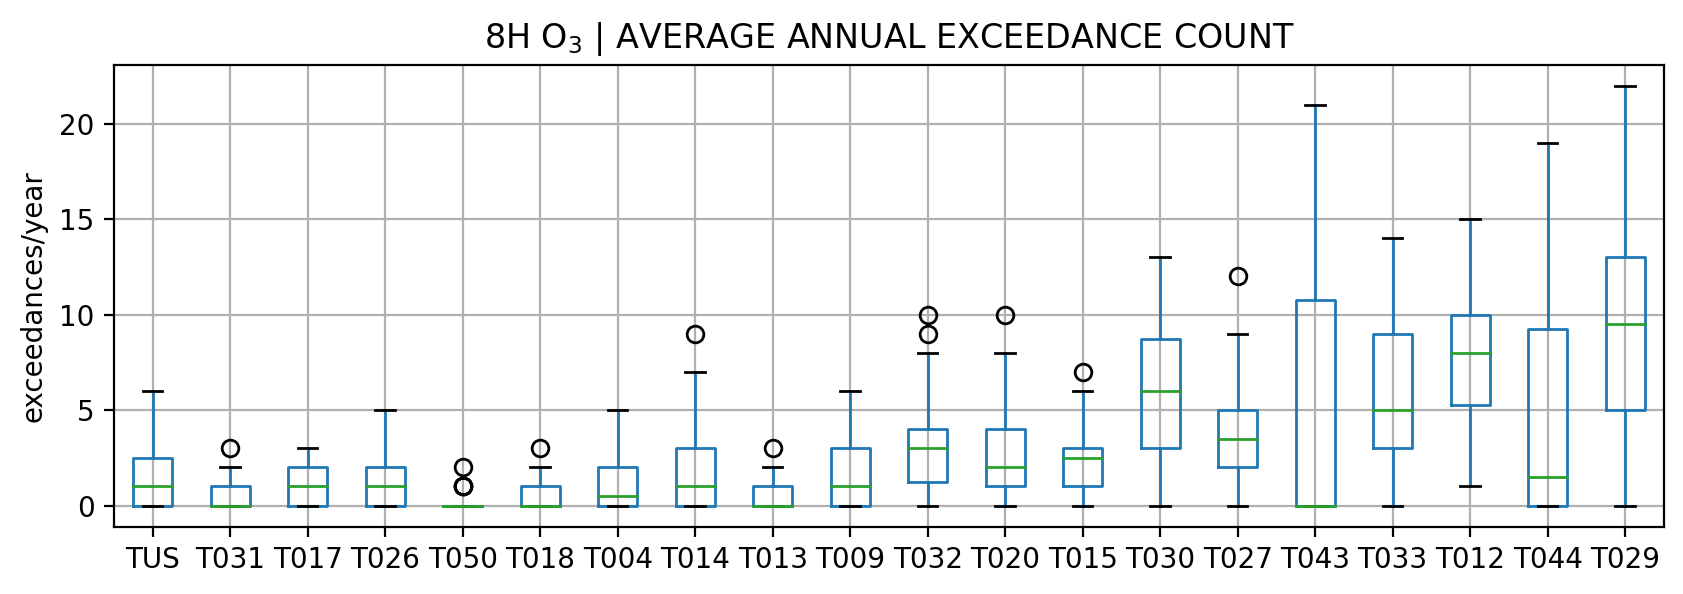

In [ ]:
sorted_stns = list(trends.loc[select_stations].sort_values('lon', ascending=False).index.values)

#Boxplots for exeedance counts and magnitudes
#---1h plots------
plt.figure(figsize=(10,4))
diff_daily_1h.boxplot(column=sorted_stns)
plt.gca().set(title='1H O$_3$ | AVERAGE ANNUAL EXCEEDANCE MAGNITUDE', ylabel='exceedance magnitude (ppb)')
plt.savefig(os.path.join(fig_path,'1H_O3_ExceedanceMag_Boxplot.pdf'),bbox_inches = 'tight')

# #too few samples
plt.figure(figsize=(10,3))
ex_cnt_1h.boxplot(column=sorted_stns)
plt.gca().set(title='1H O$_3$ | AVERAGE ANNUAL EXCEEDANCE COUNT', ylabel='exceedances/year')
plt.savefig(os.path.join(fig_path,'1H_O3_ExceedanceCnt_Boxplot.pdf'),bbox_inches = 'tight')

#------8h------
plt.figure(figsize=(10,3))
diff_daily_8h.boxplot(column=sorted_stns)
plt.gca().set(title='8H O$_3$ | AVERAGE ANNUAL EXCEEDANCE MAGNITUDE', ylabel='exceedance magnitude (ppb)')
plt.savefig(os.path.join(fig_path,'8H_O3_ExceedanceMag_Boxplot.pdf'),bbox_inches = 'tight')

plt.figure(figsize=(10,3))
ex_cnt_8h.boxplot(column=sorted_stns)
plt.gca().set(title='8H O$_3$ | AVERAGE ANNUAL EXCEEDANCE COUNT', ylabel='exceedances/year')
plt.savefig(os.path.join(fig_path,'8H_O3_ExceedanceCnt_Boxplot.pdf'),bbox_inches = 'tight')



In [ ]:
!pip install Cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 78.5 MB/s eta 0:00:00


In [ ]:
#set up google tiles - CHECK THIS IS OK TO USE!
from cartopy.io.img_tiles import GoogleTiles
import cartopy.crs as ccrs

class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

In [ ]:
#deal with colormap
import matplotlib as mpl

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

norm = MidpointNormalize(vmin=-0.1, vmax=0.4, midpoint=0)

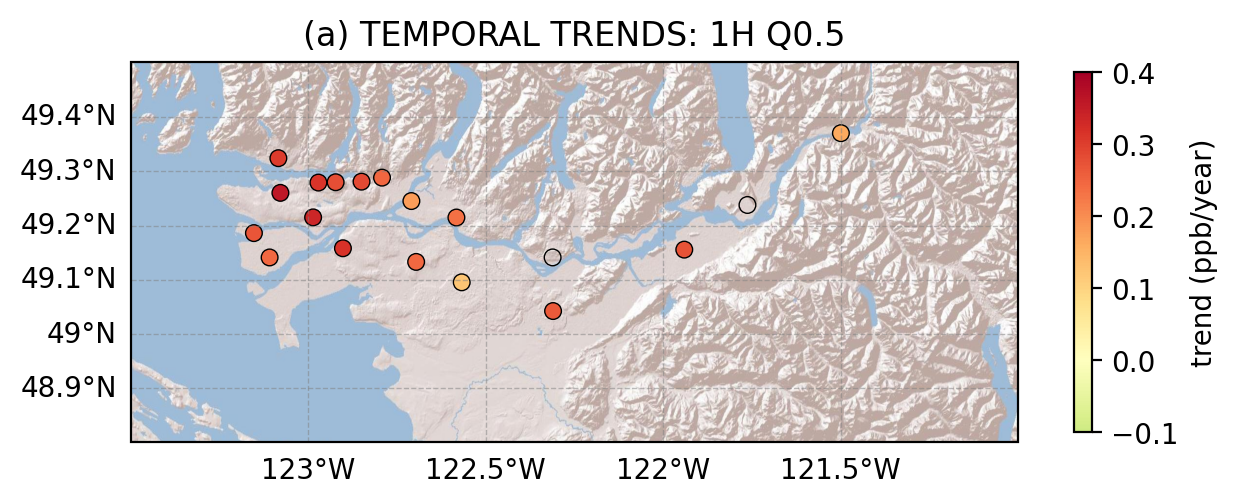

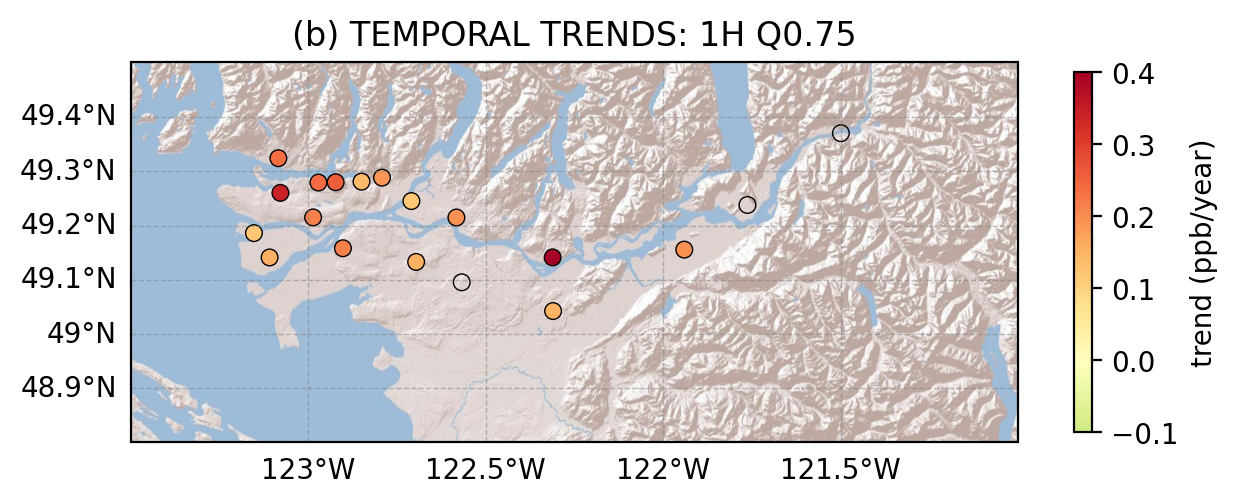

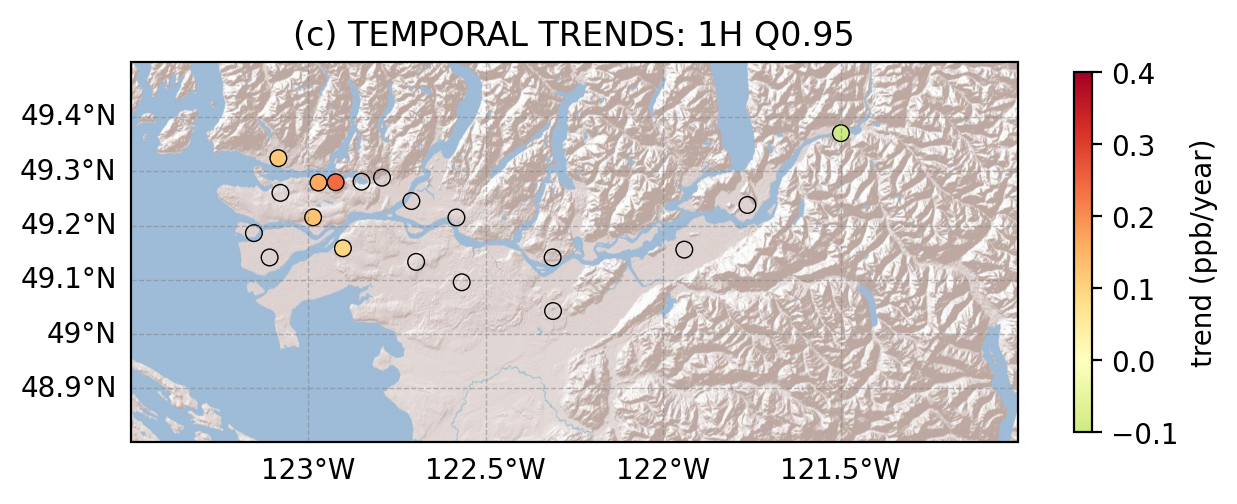

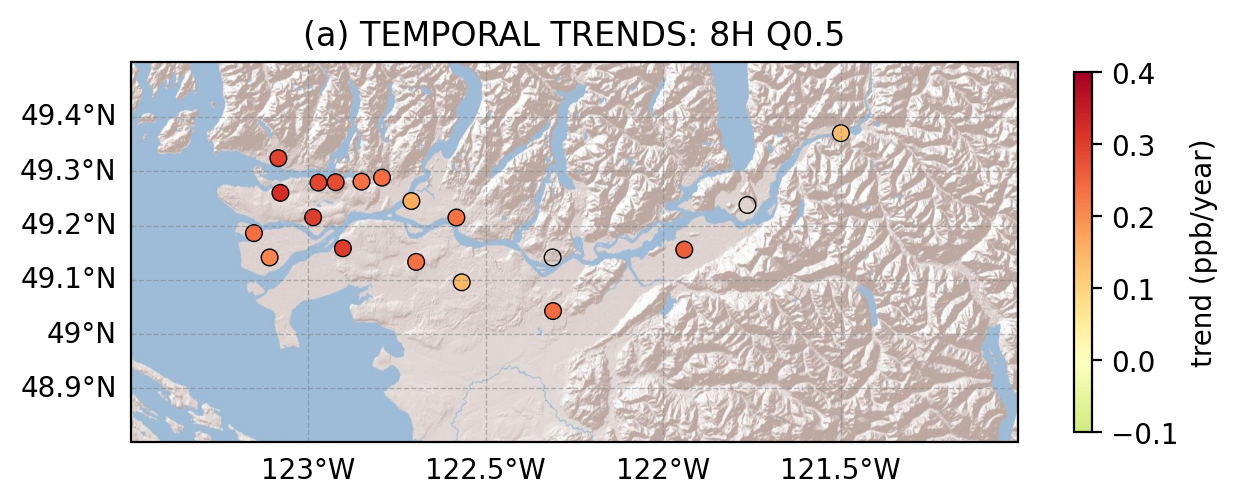

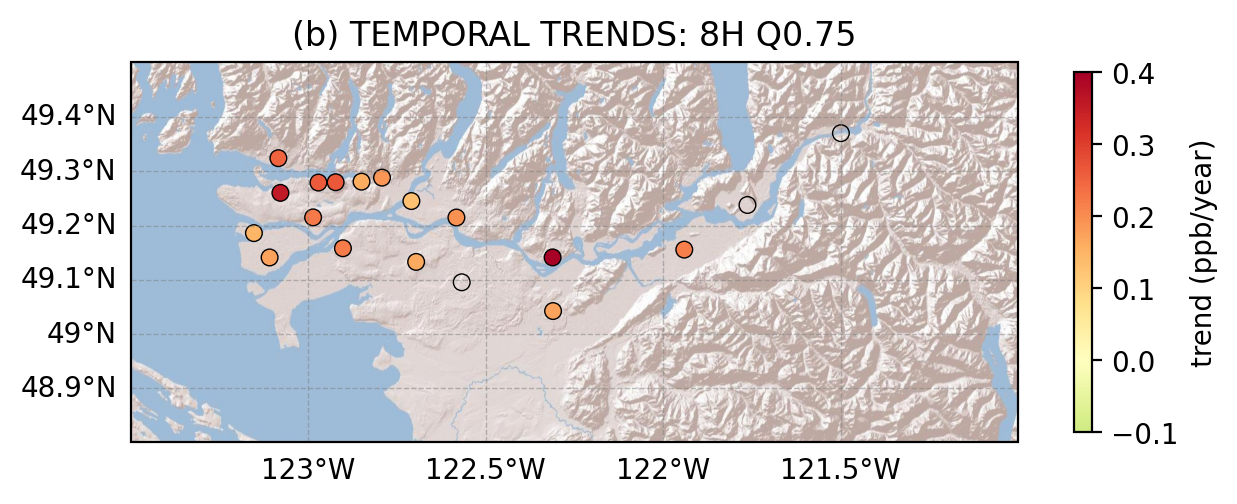

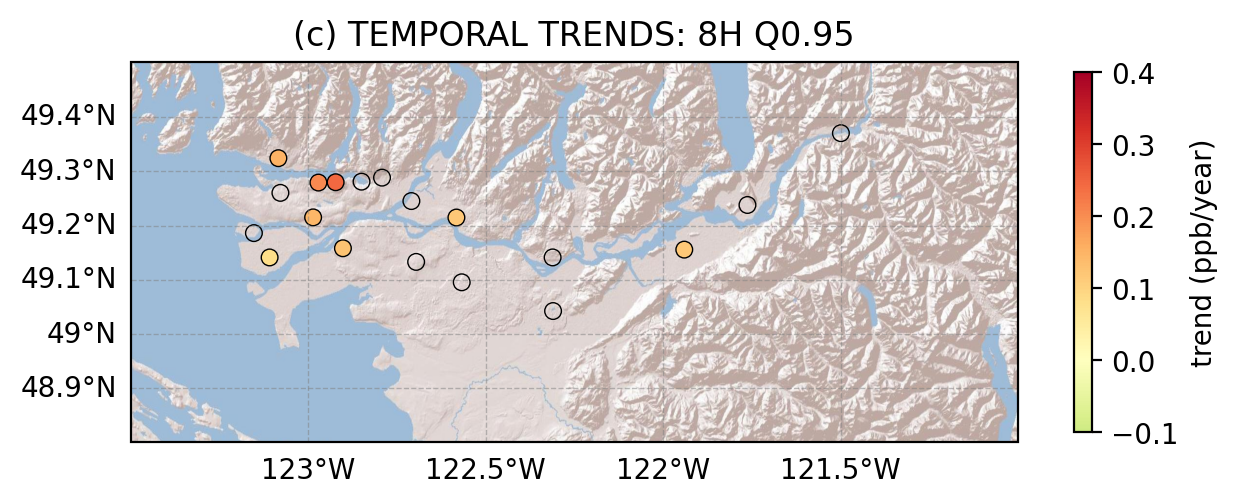

In [ ]:
#plot maps of trends
for key,tag in zip(['1H Q0.5','1H Q0.75','1H Q0.95','8H Q0.5','8H Q0.75','8H Q0.95'],['(a)','(b)','(c)','(a)','(b)','(c)']):
  plt.figure()
  ax = plt.axes(projection=ShadedReliefESRI().crs)
  ax.set_extent([-123.5, -121, 48.8, 49.5])
  ax.add_image(ShadedReliefESRI(), 10)
  scat = plt.scatter(trends.loc[select_stations].lon.values*-1, trends.loc[select_stations].lat.values,c=trends.loc[select_stations][key].values,transform=ccrs.PlateCarree(), \
                     cmap= 'RdYlGn_r',edgecolors='black',linewidth=0.5,norm=norm)
  # if tag=='(c)':
  plt.colorbar(label='trend (ppb/year)',shrink=0.4)
  gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
  gl.top_labels = False
  gl.right_labels = False
  ax.set(title=f'{tag} TEMPORAL TRENDS: {key}')
  plt.tight_layout()
  plt.savefig(os.path.join(fig_path,'map_trends',f'{key}_O3.pdf'),bbox_inches = 'tight')

In [ ]:
meta[['StationName','Lat','Lon']]

StationName        Lat         Lon
stations                                                       
T001                  DOWNTOWN VANCOUVER  49.282272  123.121880
T002                 VANCOUVER-KITSILANO  49.261672  123.163472
T004             BURNABY-KENSINGTON PARK  49.279214  122.970707
T006      NORTH VANCOUVER-SECOND NARROWS  49.301472  123.020417
T009                          PORT MOODY  49.280893  122.849291
T012                          CHILLIWACK  49.155848  121.940279
T013                         NORTH DELTA  49.158348  122.901730
T014                    BURNABY MOUNTAIN  49.279809  122.922267
T015                         SURREY EAST  49.133219  122.695491
T017                      RICHMOND SOUTH  49.141437  123.108215
T018                       BURNABY SOUTH  49.215190  122.985666
T020                        PITT MEADOWS  49.245233  122.708889
T022                    BURNABY-BURMOUNT  49.266702  122.935471
T023                BURNABY-CAPITOL HILL  49.287869  122.985630
T024                       BURNABY NORTH  49.287483  123.007975
T025                       SEYMOUR FALLS  49.440000  122.971390
T026          NORTH VANCOUVER-MAHON PARK  49.323994  123.083496
T027                             LANGLEY  49.095613  122.567104
T029                                HOPE  49.369887  121.499122
T030                         MAPLE RIDGE  49.214939  122.582057
T031                    RICHMOND AIRPORT  49.186265  123.152422
T032                           COQUITLAM  49.288264  122.791570
T033                ABBOTSFORD-MILL LAKE  49.042579  122.309821
T034                  ABBOTSFORD AIRPORT  49.032500  122.353060
T035                       HORSESHOE BAY  49.368610  123.276741
T039                          TSAWWASSEN  49.009877  123.081997
T043                             MISSION  49.141490  122.311078
T044                             AGASSIZ  49.238008  121.762264
T045                  ABBOTSFORD AIRPORT  49.021554  122.326523
T046                     NEW WESTMINSTER  49.227045  122.894487
T050               VANCOUVER CLARK DRIVE  49.260290  123.077811
TYXX                ABBOTSFORD AP MERGED  49.027027  122.339791
TUS                          CHEEKA PEAK  48.297860  124.624910

NOTES:

https://www2.gov.bc.ca/assets/gov/environment/air-land-water/air/reports-pub/prov_air_qual_objectives_fact_sheet.pdf
Ozone (O3)
1-hour  82 NAAQO9 1989
8-hour 62 2020 CAAQS* 2013

*https://gazette.gc.ca/rp-pr/p1/2013/2013-05-25/html/notice-avis-eng.html


Questions to consider:

* Achievement based on annual 4th highest daily maximum 8-hour average concentration, averaged over three consecutive years. We originally excluded this with Bruce. Reconsider?

* stations included in EC analysis, but not provided by MV :
  ec_missing = ['T001','T002','T004','T006','T013','T015','T017','T033']

* MV_stns = ['T009','T012','T014','T018','T026','T027','T029','T030','T031','T034/035','T043','T044']

* overlapping EC_stns = ['T009','T012','T018','T026','T027','T029','T030','T031','T034/035']

* 'T014' was previously excluded

* still missing whole bunch of burnaby stations and tsawassen


Spatial Analysis:
* 8h - Q95, no point, only 5 sig trends



